# Assimilating records whose PSMs cannot be calibrated

In some cases, we may need to assimilate records whose PSMs cannot be calibrated with instrumental observations due to non-overlapping timespan.
This tutorial shows how to specify the required paramters and assimilate those records without calling the calibration step of their PSMs.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import os
os.chdir('/glade/u/home/fengzhu/Github/cfr/docsrc/notebooks/')

## Create a reconstruction job object

In [2]:
job = cfr.ReconJob(verbose=True)

>>> job.configs:
{}


## Load a proxy database

In [3]:
job.load_proxydb('./data/pages2k_updated_Palmyra_dataset.pkl')

## Filter the proxy database

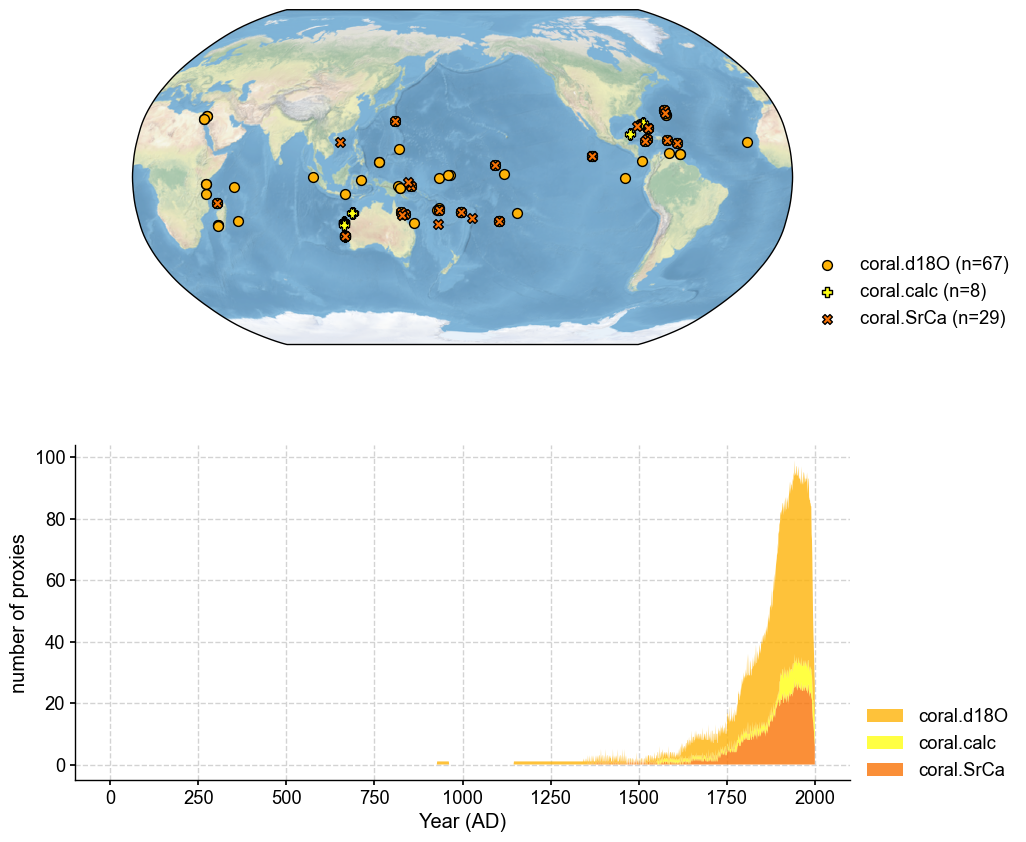

In [4]:
job.filter_proxydb(by='ptype', keys=['coral'])
# the .plot() method will generate a static map utilizing the Cartopy library
fig, ax = job.proxydb.plot(plot_count=True)

## Annualize/seasonalize the proxy database

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = ['coral']


Annualizing ProxyDatabase: 100%|██████████| 104/104 [00:05<00:00, 18.90it/s]


>>> 104 records remaining
>>> job.proxydb updated


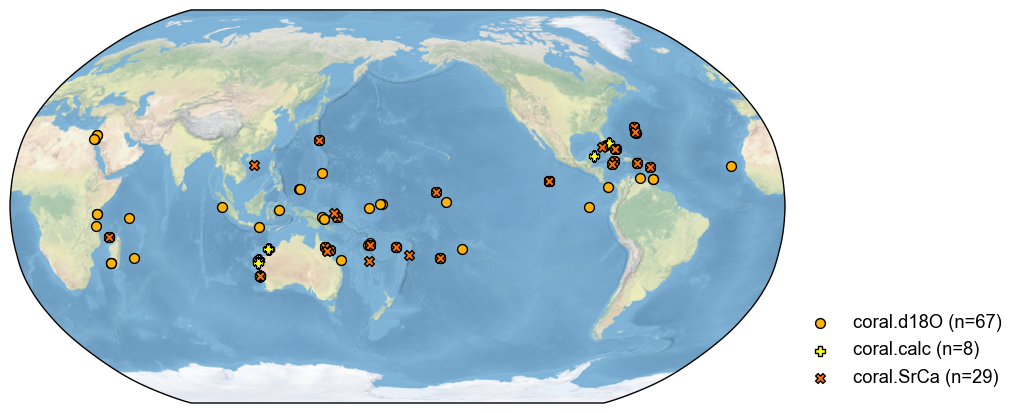

In [5]:
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'], verbose=True)
fig, ax = job.proxydb.plot()

## Load climate model priors

In [6]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lat_name"] = lat
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> prior variables ['tas'] loaded
>>> job.prior created


## Forward modeling without calling the PSMs

This is the key step of this tutorial.
Below we loop over each proxy record and perform forward modeling steps:
1. Get the climate data at the nearest grid point of the record.
2. Annualize the climate data to get the same seasonality as the record.
3. Create the `pobj.pseudo` object for each record, with `pobj.pseudo.time` and `pobj.pseudo.value` specified. The `.value` can be generated based on uncalibrated but known relationships (e.g., linear with a certain slope).
4. Add the tag "calibrated" so that the workflow will not complain.
5. Set the observation error based on estimation.


In [24]:
for pid, pobj in job.proxydb.records.items():
    pobj.get_clim(job.prior['tas'], tag='model')
    clim_ann = pobj.clim['model.tas'].annualize(months=[12, 1, 2]) 
    pobj.pseudo = pobj.copy()
    pobj.pseudo.time = clim_ann.da.time.values
    pobj.pseudo.value = clim_ann.da.values
    pobj.pseudo.seasonality = [12, 1, 2]
    pobj.tags.add('calibrated')
    pobj.R = 0.5 # obs err; should be estimated ahead

job.proxydb.nrec_tags("calibrated") # confirm that all the records have been "calibrated"

## Annualize/seasonalize the climate model prior

>>> job.configs["prior_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.prior updated


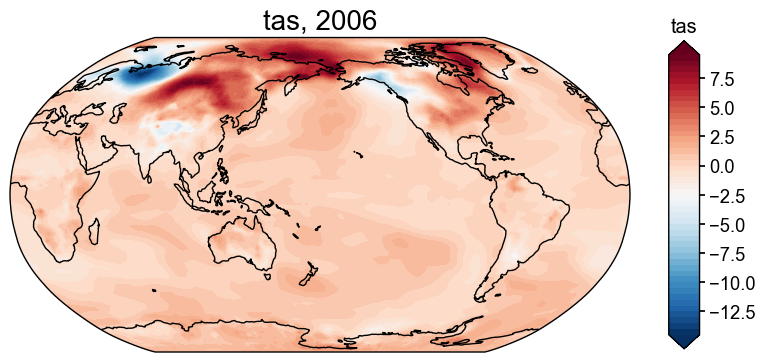

In [12]:
job.annualize_clim(tag='prior', verbose=True, months=[12, 1, 2])
fig, ax = job.prior['tas'][-1].plot()

## Regrid the prior field

In [13]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.prior['tas'].da

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...


<xarray.DataArray 'tas' (time: 1157, lat: 42, lon: 63)>
array([[[-7.81051636e-01, -9.22830397e-01, -8.39860485e-01, ...,
         -8.08501951e-01, -7.90614220e-01, -7.81051636e-01],
        [-3.78635376e-01, -4.53974174e-01, -3.50083852e-01, ...,
         -1.68662978e-01, -2.71238134e-01, -3.78635376e-01],
        [-1.40333148e+00, -1.14323499e+00, -7.99864422e-01, ...,
         -1.24427407e+00, -1.01681555e+00, -1.40333148e+00],
        ...,
        [ 1.51642582e+00,  2.00791711e+00,  2.99710145e+00, ...,
         -4.22339864e-01,  6.26514400e-01,  1.51642582e+00],
        [ 1.51600985e+00,  1.81332871e+00,  1.98969666e+00, ...,
          7.17246048e-01,  1.15366462e+00,  1.51600985e+00],
        [-6.69174158e-02, -1.14359688e-01, -1.13317414e-01, ...,
         -8.39093201e-02, -6.26213337e-02, -6.69174158e-02]],

       [[ 3.99113983e-01,  2.50226913e-01,  3.51283409e-01, ...,
          3.76062861e-01,  3.98603538e-01,  3.99113983e-01],
        [ 8.05754848e-01,  7.93750219e-01,  9.23834707e-01, ...,
          8.62339883e-01,  8.53999842e-01,  8.05754848e-01],
        [ 3.78598088e-01,  6.81967098e-01,  9.79965517e-01, ...,
          3.73871145e-01,  7.06629183e-01,  3.78598088e-01],
...
        [-4.03990123e+00, -3.95388920e+00, -3.67437595e+00, ...,
         -2.82537085e+00, -3.68772147e+00, -4.03990123e+00],
        [-3.06803562e+00, -3.13736595e+00, -3.03790458e+00, ...,
         -2.70351666e+00, -2.89840592e+00, -3.06803562e+00],
        [-1.92743434e+00, -1.87511401e+00, -1.85468563e+00, ...,
         -1.97049589e+00, -1.95583223e+00, -1.92743434e+00]],

       [[ 1.40498352e+00,  1.38947419e+00,  1.34637156e+00, ...,
          1.34081884e+00,  1.37822305e+00,  1.40498352e+00],
        [ 1.24801511e+00,  1.29332777e+00,  1.29418854e+00, ...,
          1.12494411e+00,  1.31675206e+00,  1.24801511e+00],
        [ 6.13445684e-01,  5.69961440e-01,  4.73153888e-01, ...,
          1.13487406e+00,  9.78545336e-01,  6.13445684e-01],
        ...,
        [ 2.36734526e+00,  2.68027267e+00,  2.81354434e+00, ...,
          1.76056504e+00,  2.16766833e+00,  2.36734526e+00],
        [ 2.38290957e+00,  1.92326235e+00,  1.38590705e+00, ...,
          2.66820317e+00,  2.51788330e+00,  2.38290957e+00],
        [ 1.39060974e+00,  1.33488022e+00,  1.31009797e+00, ...,
          1.42522898e+00,  1.41616427e+00,  1.39060974e+00]]])
Coordinates:
  * time     (time) int64 850 851 852 853 854 855 ... 2002 2003 2004 2005 2006
  * lat      (lat) float64 -90.0 -85.61 -81.22 -76.83 ... 76.83 81.22 85.61 90.0
  * lon      (lon) float64 0.0 5.806 11.61 17.42 ... 342.6 348.4 354.2 360.0
Attributes:
    annualized:  1

## Crop the prior field

>>> job.configs["prior_lat_min"] = -35
>>> job.configs["prior_lat_max"] = 35
>>> job.configs["prior_lon_min"] = 0
>>> job.configs["prior_lon_max"] = 360
>>> Processing tas ...


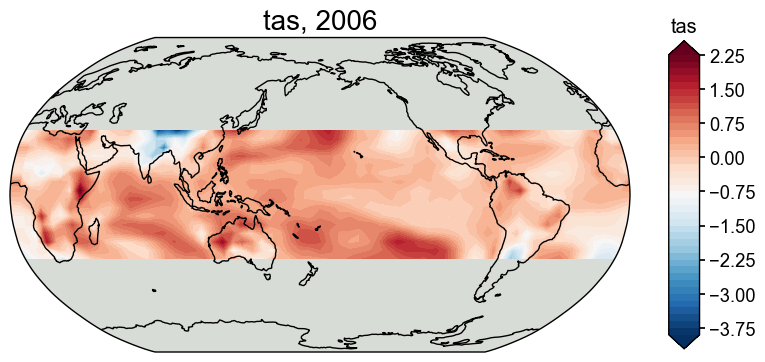

In [14]:
job.crop_clim(tag='prior', lat_min=-35, lat_max=35, verbose=True)
fig, ax = job.prior['tas'][-1].plot()

## Data assimilation

In [26]:
job.run_da_mc(
    save_dirpath='./recons/lmr-no-calib',
    recon_period=(1801, 2000),
    recon_seeds=list(range(1, 2)), verbose=True)

>>> job.configs["recon_period"] = (1801, 2000)
>>> job.configs["recon_seeds"] = [1]
>>> job.configs["save_dirpath"] = ./recons/lmr-no-calib
>>> seed: 1 | max: 1


KF updating: 100%|██████████| 200/200 [00:13<00:00, 15.07it/s]


>>> Reconstructed fields saved to: ./recons/lmr-no-calib/job_r01_recon.nc
>>> DONE! Total time spent: 0.24 mins.


## Validation

In [27]:
res = cfr.ReconRes('./recons/lmr-no-calib', verbose=True)

>>> res.paths:
['./recons/lmr-no-calib/job_r01_recon.nc']


In [28]:
res.load(['nino3.4', 'tas'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created


In [29]:
import scipy.io as sio
import numpy as np

data = sio.loadmat('./data/BC09_NINO34.mat')
start_yr = 1874
end_yr = 2000
nyr = end_yr-start_yr+1
nino34 = np.zeros(nyr)
for i in range(nyr):
    nino34[i] = np.mean(data['nino34'][12+i*12:14+i*12])

ref_value = nino34
ref_time = np.arange(start_yr, end_yr+1)
ref_name = 'BC09'

Text(0, 0.5, 'NINO3.4 [K]')

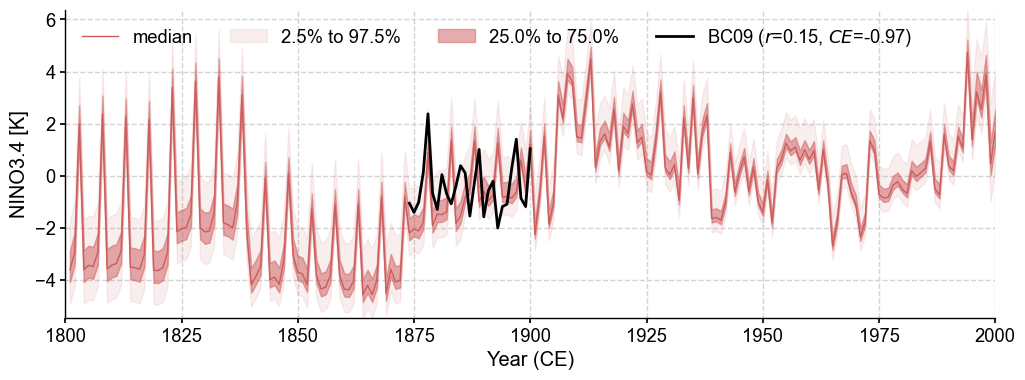

In [30]:
fig, ax = res.recons['nino3.4'].compare(
    ref_time, ref_value, ref_name, timespan=(1874, 1900)).plot_qs()
ax.set_xlim(1800, 2000)
ax.set_ylabel('NINO3.4 [K]')

The above reconstruction shows that, without proper calibration of the PSMs, the posterior can become weired due to the inaccurate estimate of the observation error and the inaccurate forward modeling relationship.